In [ ]:
pip install category_encoders

     |████████████████████████████████| 81kB 4.6MB/s 


In [ ]:
pip install neptune-client

     |████████████████████████████████| 92kB 3.0MB/s 
     |████████████████████████████████| 829kB 6.9MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 204kB 12.6MB/s 
     |████████████████████████████████| 163kB 13.6MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 133kB 13.8MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.125-py2.py3-none-any.whl size=151812 sha256=0bbd2ec646c703b6da383fc1c2d0c10dbe866b5af4a6e556583276f864268307
  Stored in directory: /root/.cache/pip/wheels/fc/f1/47/d7b65b61a1d16995ca4e474f5dcc215459770e9438842f6de8
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=1222f999555be355b66c40a686a7ba4da07936c73063613afa5754776b819c1e
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for s

In [ ]:
import pandas as pd
import numpy as np

from collections import Counter

from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/noshow_processed_data.csv', index_col = 'Unnamed: 0')
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4


In [ ]:
dataset.rename(columns = {'ScheduledDay': 'BookingDate',}, inplace = True)
dataset['BookingDate'] = pd.to_datetime(dataset['BookingDate']).dt.date.astype('datetime64[ns]')

In [ ]:
dataset.rename(columns = {'AppointmentDay' : 'AppointmentDate'}, inplace = True)
dataset['AppointmentDate'] = pd.to_datetime(dataset['AppointmentDate']).dt.date.astype('datetime64[ns]')

In [ ]:
dataset.rename(columns = {'Hipertension': 'Hypertension'},inplace = True)

In [ ]:
dataset.rename(columns = {'Handcap': 'Handicap'}, inplace = True)

In [ ]:
dataset.rename(columns = {'SMS_received': 'SMSReceived'}, inplace = True)

In [ ]:
dataset.rename(columns = {'No-show': 'NoShow'}, inplace = True)

In [ ]:
dataset['YearBookingDate'] = dataset['BookingDate'].dt.year

In [ ]:
dataset['MonthBookingDate'] = dataset['BookingDate'].dt.month

In [ ]:
dataset['DayBookingDate'] = dataset['BookingDate'].dt.day

In [ ]:
dataset['YearAppointmentDate'] = dataset['AppointmentDate'].dt.year

In [ ]:
dataset['MonthAppointmentDate'] = dataset['AppointmentDate'].dt.month

In [ ]:
dataset['DayAppointmentDate'] = dataset['AppointmentDate'].dt.day

In [ ]:
dataset

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,0,2016-05-03,2016-06-07,56,22,0,0,0,0,0,1,0,9,35,1,2016,5,3,2016,6,7
110523,3596266328735,0,2016-05-03,2016-06-07,51,22,0,0,0,0,0,1,0,7,35,1,2016,5,3,2016,6,7
110524,15576631729893,0,2016-04-27,2016-06-07,21,22,0,0,0,0,0,1,0,16,41,1,2016,4,27,2016,6,7
110525,92134931435557,0,2016-04-27,2016-06-07,38,22,0,0,0,0,0,1,0,15,41,1,2016,4,27,2016,6,7


In [ ]:
dataset['VisitCount'] = dataset.groupby('PatientId')['PatientId'].transform('count')
dataset

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29,2
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29,2
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,0,2016-05-03,2016-06-07,56,22,0,0,0,0,0,1,0,9,35,1,2016,5,3,2016,6,7,2
110523,3596266328735,0,2016-05-03,2016-06-07,51,22,0,0,0,0,0,1,0,7,35,1,2016,5,3,2016,6,7,4
110524,15576631729893,0,2016-04-27,2016-06-07,21,22,0,0,0,0,0,1,0,16,41,1,2016,4,27,2016,6,7,1
110525,92134931435557,0,2016-04-27,2016-06-07,38,22,0,0,0,0,0,1,0,15,41,1,2016,4,27,2016,6,7,2


In [ ]:
dataset['NoshowCount'] = dataset.loc[dataset['NoShow'] == 1].groupby('PatientId')['PatientId'].transform('count')

In [ ]:
dataset.head(10)

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29,2,NaN
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,NaN
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,NaN
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29,2,NaN
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29,1,NaN
5,95985133231274,0,2016-04-27,2016-04-29,76,3,0,1,0,0,0,0,0,9,2,4,2016,4,27,2016,4,29,2,NaN
6,733688164476661,0,2016-04-27,2016-04-29,23,4,0,0,0,0,0,0,1,15,2,4,2016,4,27,2016,4,29,1,1.0
7,3449833394123,0,2016-04-27,2016-04-29,39,4,0,0,0,0,0,0,1,16,2,4,2016,4,27,2016,4,29,2,2.0
8,56394729949972,0,2016-04-29,2016-04-29,21,5,0,0,0,0,0,0,0,8,0,4,2016,4,29,2016,4,29,1,NaN
9,78124564369297,0,2016-04-27,2016-04-29,19,6,0,0,0,0,0,0,0,13,2,4,2016,4,27,2016,4,29,1,NaN


In [ ]:
dataset['NoshowCount']=dataset['NoshowCount'].fillna(0)

In [ ]:
dataset.head(10)

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29,2,0.0
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29,2,0.0
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29,1,0.0
5,95985133231274,0,2016-04-27,2016-04-29,76,3,0,1,0,0,0,0,0,9,2,4,2016,4,27,2016,4,29,2,0.0
6,733688164476661,0,2016-04-27,2016-04-29,23,4,0,0,0,0,0,0,1,15,2,4,2016,4,27,2016,4,29,1,1.0
7,3449833394123,0,2016-04-27,2016-04-29,39,4,0,0,0,0,0,0,1,16,2,4,2016,4,27,2016,4,29,2,2.0
8,56394729949972,0,2016-04-29,2016-04-29,21,5,0,0,0,0,0,0,0,8,0,4,2016,4,29,2016,4,29,1,0.0
9,78124564369297,0,2016-04-27,2016-04-29,19,6,0,0,0,0,0,0,0,13,2,4,2016,4,27,2016,4,29,1,0.0


In [ ]:
dataset['NoShowPercent']= dataset['NoshowCount']/dataset['VisitCount']*100


In [ ]:
dataset.head(10)

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29,2,0.0,0.0
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0,0.0
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0,0.0
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29,2,0.0,0.0
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29,1,0.0,0.0
5,95985133231274,0,2016-04-27,2016-04-29,76,3,0,1,0,0,0,0,0,9,2,4,2016,4,27,2016,4,29,2,0.0,0.0
6,733688164476661,0,2016-04-27,2016-04-29,23,4,0,0,0,0,0,0,1,15,2,4,2016,4,27,2016,4,29,1,1.0,100.0
7,3449833394123,0,2016-04-27,2016-04-29,39,4,0,0,0,0,0,0,1,16,2,4,2016,4,27,2016,4,29,2,2.0,100.0
8,56394729949972,0,2016-04-29,2016-04-29,21,5,0,0,0,0,0,0,0,8,0,4,2016,4,29,2016,4,29,1,0.0,0.0
9,78124564369297,0,2016-04-27,2016-04-29,19,6,0,0,0,0,0,0,0,13,2,4,2016,4,27,2016,4,29,1,0.0,0.0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   PatientId             110521 non-null  int64         
 1   Gender                110521 non-null  int64         
 2   BookingDate           110521 non-null  datetime64[ns]
 3   AppointmentDate       110521 non-null  datetime64[ns]
 4   Age                   110521 non-null  int64         
 5   Neighbourhood         110521 non-null  int64         
 6   Scholarship           110521 non-null  int64         
 7   Hypertension          110521 non-null  int64         
 8   Diabetes              110521 non-null  int64         
 9   Alcoholism            110521 non-null  int64         
 10  Handicap              110521 non-null  int64         
 11  SMSReceived           110521 non-null  int64         
 12  NoShow                110521 non-null  int64         
 13 

In [ ]:
dataset['BookingWeekday'] = dataset['BookingDate'].dt.dayofweek

#dataset['AppointmentWeekday'] = dataset['AppointmentDay'].dt.dayofweek

In [ ]:
dataset.head()

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,2,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29,1,0.0,0.0,4


In [ ]:
dataset[dataset['Age']<0]

,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday


In [ ]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Neighbourhood'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,19,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,16,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,17,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,16,0,4,2016,4,29,2016,4,29,1,0.0,0.0,4


In [ ]:
dataset.columns

Index(['PatientId', 'Gender', 'BookingDate', 'AppointmentDate', 'Age',
       'Neighbourhood_0', 'Neighbourhood_1', 'Neighbourhood_2',
       'Neighbourhood_3', 'Neighbourhood_4', 'Neighbourhood_5',
       'Neighbourhood_6', 'Neighbourhood_7', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived', 'NoShow',
       'BookHour', 'DaysToAppointment', 'AppointmentWeekDay',
       'YearBookingDate', 'MonthBookingDate', 'DayBookingDate',
       'YearAppointmentDate', 'MonthAppointmentDate', 'DayAppointmentDate',
       'VisitCount', 'NoshowCount', 'NoShowPercent', 'BookingWeekday'],
      dtype='object')

In [ ]:
encoder = ce.BinaryEncoder(cols=['BookHour'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,4,2016,4,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,4,2016,4,29,2016,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['DaysToAppointment'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,4,2016,4,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4,2016,4,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4,2016,4,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,4,2016,4,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4,2016,4,29,2016,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['AppointmentWeekDay'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,2016,4,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2016,4,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2016,4,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,2016,4,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2016,4,29,2016,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['YearBookingDate'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate_0,YearBookingDate_1,MonthBookingDate,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,4,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,4,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,4,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,4,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,4,29,2016,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['MonthBookingDate'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate_0,YearBookingDate_1,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,29,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,29,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,29,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,29,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,29,2016,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['DayBookingDate'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate_0,YearBookingDate_1,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,YearAppointmentDate,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2016,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2016,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2016,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2016,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2016,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['YearAppointmentDate'])
dataset = encoder.fit_transform(dataset)

dataset.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate_0,YearBookingDate_1,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,YearAppointmentDate_0,MonthAppointmentDate,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,4,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,4,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,4,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,4,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,4,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['MonthAppointmentDate'])
dataset = encoder.fit_transform(dataset)

dataset.head()


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate_0,YearBookingDate_1,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,YearAppointmentDate_0,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate,VisitCount,NoshowCount,NoShowPercent,BookingWeekday
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,29,2,0.0,0.0,4
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,29,2,0.0,0.0,4
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,29,2,0.0,0.0,4
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,29,2,0.0,0.0,4
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,29,1,0.0,0.0,4


In [ ]:
encoder = ce.BinaryEncoder(cols=['BookingWeekday'])
dataset = encoder.fit_transform(dataset)

dataset.head()


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PatientId,Gender,BookingDate,AppointmentDate,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,BookHour_0,BookHour_1,BookHour_2,BookHour_3,BookHour_4,DaysToAppointment_0,DaysToAppointment_1,DaysToAppointment_2,DaysToAppointment_3,DaysToAppointment_4,DaysToAppointment_5,DaysToAppointment_6,DaysToAppointment_7,DaysToAppointment_8,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,YearBookingDate_0,YearBookingDate_1,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,YearAppointmentDate_0,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,VisitCount,NoshowCount,NoShowPercent,BookingWeekday_0,BookingWeekday_1,BookingWeekday_2,BookingWeekday_3
0,29872499824296,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,2,0.0,0.0,0,0,0,1
1,558997776694438,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,2,0.0,0.0,0,0,0,1
2,4262962299951,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,2,0.0,0.0,0,0,0,1
3,867951213174,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,2,0.0,0.0,0,0,0,1
4,8841186448183,0,2016-04-29,2016-04-29,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0.0,0.0,0,0,0,1


In [ ]:
encoder = ce.BinaryEncoder(cols=['DayAppointmentDate'])
dataset = encoder.fit_transform(dataset)

dataset.head()


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 67 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   PatientId               110521 non-null  int64         
 1   Gender                  110521 non-null  int64         
 2   BookingDate             110521 non-null  datetime64[ns]
 3   AppointmentDate         110521 non-null  datetime64[ns]
 4   Age                     110521 non-null  int64         
 5   Neighbourhood_0         110521 non-null  int64         
 6   Neighbourhood_1         110521 non-null  int64         
 7   Neighbourhood_2         110521 non-null  int64         
 8   Neighbourhood_3         110521 non-null  int64         
 9   Neighbourhood_4         110521 non-null  int64         
 10  Neighbourhood_5         110521 non-null  int64         
 11  Neighbourhood_6         110521 non-null  int64         
 12  Neighbourhood_7         110521

In [ ]:
dataset.drop(['BookingDate','AppointmentDate'], axis=1, inplace=True)

In [ ]:
def model(X, y, model, name, tags):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  print()
  model = model()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
      'recall', recall_score(y_test, y_pred), '\n',
      'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags([str(model),"Magdalena Cebula"])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  #roc
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [ ]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow') & (feats != 'NoshowCount')  & (feats != 'NoShowPercent')].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='NoShow'):
    return df[target_var].values

In [ ]:
X1= get_X(dataset)
y1 = get_y(dataset)

In [ ]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Accuracy: 86.76%
 f1  0.8573616835041394 
 recall 0.7983969569351991 
 precision 0.9257304875167363
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-82
Confusion matrix:
 [[13882   943]
 [ 2968 11754]]


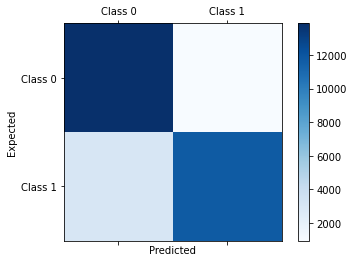

[0.         0.06360877 1.        ] [0.         0.79839696 1.        ] [2 1 0]


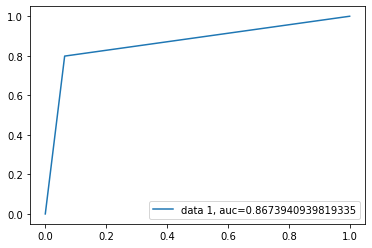

In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_stomek1, y_stomek1 = smote_tomek.fit_resample(X1, y1)
model(X_stomek1, y_stomek1, XGBClassifier, "SMOTETomek", ['VisitCount', "SMOTETomek"])

In [ ]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow') & (feats != 'NoShowPercent')].values

X2= get_X(dataset)
y2 = get_y(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Accuracy: 100.00%
 f1  1.0 
 recall 1.0 
 precision 1.0
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-83
Confusion matrix:
 [[15055     0]
 [    0 14723]]


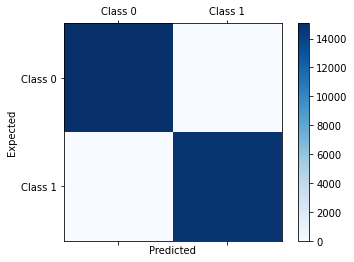

[0. 0. 1.] [0. 1. 1.] [2 1 0]


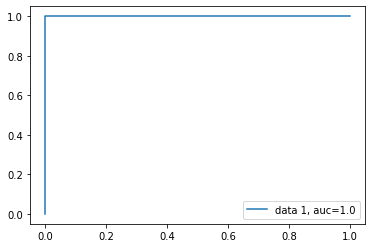

In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_stomek1, y_stomek1 = smote_tomek.fit_resample(X2, y2)
model(X_stomek1, y_stomek1, XGBClassifier, "SMOTETomek", ['VisitCount', 'NoshowCount', "SMOTETomek"])

In [ ]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow')].values

X3 = get_X(dataset)
y3 = get_y(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Accuracy: 100.00%
 f1  1.0 
 recall 1.0 
 precision 1.0
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-85
Confusion matrix:
 [[15213     0]
 [    0 15248]]


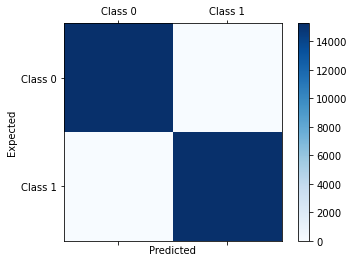

[0. 0. 1.] [0. 1. 1.] [2 1 0]


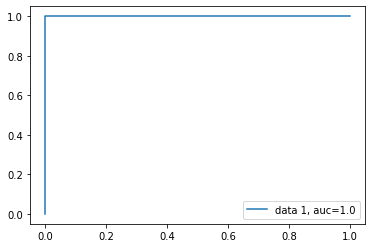

In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_stomek1, y_stomek1 = smote_tomek.fit_resample(X3, y3)
model(X_stomek1, y_stomek1, XGBClassifier, "SMOTETomek", ['VisitCount', 'NoshowCount', 'NoShowPercent', "SMOTETomek"])

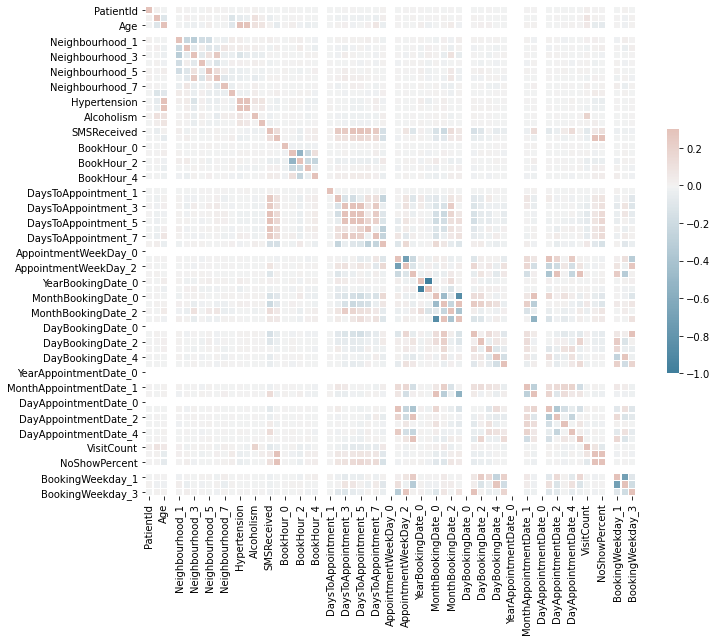

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = dataset.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,vmax=.3, cmap=cmap,center=0,
             linewidths=.5, cbar_kws={"shrink": .5})